In [ ]:
import pandas as pd
from pathlib import Path

csv_path = Path(r"C:\Users\clint\Desktop\Remitances\Data\29.csv")

if not csv_path.exists():
    raise FileNotFoundError(f"CSV not found: {csv_path}")

df_29 = pd.read_csv(csv_path, low_memory=False)
print(df_29.shape)
df_29

In [ ]:
# filter rows where Source mentions "Roland Kpodar (IMF)" and display the Source column (plus a quick preview)
mask = df_29['Source'].astype(str).str.contains('Roland Kpodar', na=False)
print("Matching rows:", mask.sum())
print("Unique Source values for matches:", df_29.loc[mask, 'Source'].unique())
df_29.loc[mask]

In [ ]:
# create a new dataframe from the previously computed mask
df_29_roland_kpodar = df_29.loc[mask].copy()

# quick check
print("Rows:", df_29_roland_kpodar.shape[0], "Columns:", df_29_roland_kpodar.shape[1])
df_29_roland_kpodar

In [ ]:
# Convert Value column to numeric before aggregation (it's stored as strings)
df_29_roland_kpodar['Value'] = pd.to_numeric(df_29_roland_kpodar['Value'], errors='coerce')

# Aggregate by receiving_country and year, summing the value column
df_aggregated = df_29_roland_kpodar.groupby(['Receiving_Country', 'Year'])['Value'].sum().reset_index()

# Sort by receiving_country and year for better readability
df_aggregated = df_aggregated.sort_values(['Receiving_Country', 'Year'])

print(f"Aggregated shape: {df_aggregated.shape}")
print(f"\nSample - Armenia 2018:")
print(df_aggregated[(df_aggregated['Receiving_Country'] == 'Armenia') & (df_aggregated['Year'] == 2018)])
print(f"\nValue column dtype after aggregation: {df_aggregated['Value'].dtype}")

df_aggregated

In [22]:
import pycountry

# Manual mappings for countries that need special handling
manual_mappings = {
    'Bahamas. The': 'BHS',  # The Bahamas
    'Congo. Dem. Rep.': 'COD',  # Democratic Republic of the Congo
    'Congo. Rep.': 'COG',  # Republic of the Congo
    'Cote d\'Ivoire': 'CIV',  # Côte d'Ivoire
    'Egypt. Arab Rep.': 'EGY',  # Egypt
    'Gambia. The': 'GMB',  # The Gambia
    'Iran. Islamic Rep.': 'IRN',  # Iran
    'Korea. Dem. People\'s Rep.': 'PRK',  # North Korea
    'Korea. Rep.': 'KOR',  # South Korea
    'Kyrgyz Republic': 'KGZ',  # Kyrgyzstan
    'Lao PDR': 'LAO',  # Laos
    'Slovak Republic': 'SVK',  # Slovakia
    'Venezuela. RB': 'VEN',  # Venezuela
    'Yemen. Rep.': 'YEM',  # Yemen
    'Micronesia. Fed. Sts.': 'FSM',  # Federated States of Micronesia
    'St. Kitts and Nevis': 'KNA',  # Saint Kitts and Nevis
    'St. Lucia': 'LCA',  # Saint Lucia
    'St. Vincent and the Grenadines': 'VCT',  # Saint Vincent and the Grenadines
}

additional_corrections = {
    # Republics and special cases
    'Republic': 'LAO',  # Specifically map "Republic" to Laos
    'Central African Republic': 'CAF',
    'Czech Republic': 'CZE', 
    'Dominican Republic': 'DOM',
    'Republic of Korea': 'KOR',  # South Korea
    'Republic of Moldova': 'MDA',
    'Syrian Arab Republic': 'SYR',
    'United Republic of Tanzania': 'TZA',
    
    # China and related territories
    'China': 'CHN',
    'China, Hong Kong SAR': 'HKG',  # Hong Kong has its own code
    'China, Macao SAR': 'MAC',      # Macao has its own code  
    'China, Taiwan Province of': 'TWN',  # Taiwan
    'Hong Kong SAR. China': 'HKG',
    'Macao SAR. China': 'MAC',
    
    # Truncated or problematic names
    'Dem. People\'s Republic of ..': 'PRK',  # North Korea
    'Democratic Republic of the': 'COD',     # DR Congo
    'Grenadines': 'VCT',                     # St. Vincent and the Grenadines
    'Channel Islands': 'GGY',                # Guernsey as representative
    
    # Other specific mappings
    'Bahamas. The': 'BHS',
    'Congo. Dem. Rep.': 'COD',
    'Congo. Rep.': 'COG', 
    'Cote d\'Ivoire': 'CIV',
    'Egypt. Arab Rep.': 'EGY',
    'Gambia. The': 'GMB',
    'Iran. Islamic Rep.': 'IRN',
    'Korea. Dem. People\'s Rep.': 'PRK',
    'Korea. Rep.': 'KOR',
    'Kyrgyz Republic': 'KGZ',
    'Lao PDR': 'LAO',
    'Slovak Republic': 'SVK',
    'Venezuela. RB': 'VEN',
    'Yemen. Rep.': 'YEM',
    'Micronesia. Fed. Sts.': 'FSM',
    'St. Kitts and Nevis': 'KNA',
    'St. Lucia': 'LCA',
    'St. Vincent and the Grenadines': 'VCT',
}

# Combine both mapping dictionaries
all_mappings = {**manual_mappings, **additional_corrections}

# Function to get country code
def get_country_code(country_name):
    if pd.isna(country_name):
        return None
    
    # Check manual mappings first
    if country_name in all_mappings:
        return all_mappings[country_name]
    
    # Try pycountry fuzzy search
    try:
        result = pycountry.countries.search_fuzzy(country_name)
        return result[0].alpha_3
    except:
        return None

# Add country code column to df_aggregated
df_aggregated['Country_Code'] = df_aggregated['Receiving_Country'].apply(get_country_code)

# Check for any unmapped countries
unmapped = df_aggregated[df_aggregated['Country_Code'].isna()]['Receiving_Country'].unique()
if len(unmapped) > 0:
    print(f"Warning: {len(unmapped)} countries could not be mapped:")
    print(unmapped)
else:
    print("All countries successfully mapped!")

print(f"\nTotal unique countries: {df_aggregated['Receiving_Country'].nunique()}")
print(f"Successfully mapped: {df_aggregated['Country_Code'].notna().sum()} rows")

df_aggregated

['Korea. Dem. People’s Rep.' 'St. Martin (French part)' 'Turkey'
 'Virgin Islands (U.S.)' 'West Bank and Gaza']

Total unique countries: 214
Successfully mapped: 627 rows


,Receiving_Country,Year,Value,Country_Code
0,Afghanistan,2018,0.048635,AFG
1,Afghanistan,2019,0.032250,AFG
2,Afghanistan,2020,0.040370,AFG
3,Albania,2018,0.033066,ALB
4,Albania,2019,0.047893,ALB
...,...,...,...,...
637,Zambia,2019,0.001165,ZMB
638,Zambia,2020,0.000978,ZMB
639,Zimbabwe,2018,0.008487,ZWE
640,Zimbabwe,2019,0.000353,ZWE


In [23]:
imf_wb_path = Path(r"C:\Users\clint\Desktop\Remitances\Data\IMF_WB_Remitance.csv")

if not imf_wb_path.exists():
    raise FileNotFoundError(f"CSV not found: {imf_wb_path}")

df_imf_wb = pd.read_csv(imf_wb_path, low_memory=False)
print("Loaded:", imf_wb_path)
print("Shape:", df_imf_wb.shape)
df_imf_wb

Loaded: C:\Users\clint\Desktop\Remitances\Data\IMF_WB_Remitance.csv
Shape: (266, 69)


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Aruba,ABW,"Personal remittances, received (current US$)",BX.TRF.PWKR.CD.DT,NaN,NaN,NaN,NaN,NaN,NaN,...,5.364010e+07,5.268434e+07,5.614049e+07,3.692030e+07,3.426402e+07,3.498404e+07,3.584564e+07,3.827949e+07,3.896426e+07,NaN
1,Africa Eastern and Southern,AFE,"Personal remittances, received (current US$)",BX.TRF.PWKR.CD.DT,NaN,NaN,NaN,NaN,NaN,NaN,...,1.096848e+10,1.018386e+10,1.067495e+10,1.495713e+10,1.435823e+10,1.371383e+10,1.686042e+10,2.033688e+10,2.146509e+10,1.778441e+09
2,Afghanistan,AFG,"Personal remittances, received (current US$)",BX.TRF.PWKR.CD.DT,NaN,NaN,NaN,NaN,NaN,NaN,...,3.486247e+08,6.277108e+08,8.227316e+08,8.035465e+08,8.285719e+08,7.889171e+08,3.200000e+08,3.200000e+08,3.200000e+08,NaN
3,Africa Western and Central,AFW,"Personal remittances, received (current US$)",BX.TRF.PWKR.CD.DT,NaN,NaN,NaN,NaN,NaN,NaN,...,3.121737e+10,2.842870e+10,3.160172e+10,3.456413e+10,3.497810e+10,2.922822e+10,3.051264e+10,3.265741e+10,3.317461e+10,2.215785e+10
4,Angola,AGO,"Personal remittances, received (current US$)",BX.TRF.PWKR.CD.DT,NaN,NaN,NaN,NaN,NaN,NaN,...,1.111471e+07,3.988048e+06,1.418196e+06,1.579247e+06,3.445473e+06,8.053051e+06,1.263115e+07,1.400549e+07,1.206657e+07,1.410659e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,XKX,"Personal remittances, received (current US$)",BX.TRF.PWKR.CD.DT,NaN,NaN,NaN,NaN,NaN,NaN,...,9.714164e+08,9.857985e+08,1.112078e+09,1.235728e+09,1.248991e+09,1.436088e+09,1.695070e+09,1.612854e+09,1.832627e+09,NaN
262,"Yemen, Rep.",YEM,"Personal remittances, received (current US$)",BX.TRF.PWKR.CD.DT,NaN,NaN,NaN,NaN,NaN,NaN,...,3.350500e+09,3.770584e+09,3.770584e+09,3.770584e+09,3.770584e+09,3.770584e+09,3.770584e+09,3.770584e+09,3.770584e+09,NaN
263,South Africa,ZAF,"Personal remittances, received (current US$)",BX.TRF.PWKR.CD.DT,NaN,NaN,NaN,NaN,NaN,NaN,...,8.252535e+08,7.554340e+08,8.738612e+08,9.290434e+08,8.900593e+08,8.108816e+08,9.266508e+08,8.728556e+08,8.033856e+08,8.553747e+08
264,Zambia,ZMB,"Personal remittances, received (current US$)",BX.TRF.PWKR.CD.DT,NaN,NaN,NaN,NaN,NaN,NaN,...,4.704654e+07,3.846444e+07,9.364410e+07,1.069656e+08,9.825912e+07,1.348648e+08,2.397094e+08,2.434860e+08,2.456881e+08,NaN


In [24]:
# First, let's examine df_imf_wb structure to understand the year columns
print("df_imf_wb columns:")
print(df_imf_wb.columns.tolist())
print(f"\nShape: {df_imf_wb.shape}")
df_imf_wb

df_imf_wb columns:
['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']

Shape: (266, 69)


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Aruba,ABW,"Personal remittances, received (current US$)",BX.TRF.PWKR.CD.DT,NaN,NaN,NaN,NaN,NaN,NaN,...,5.364010e+07,5.268434e+07,5.614049e+07,3.692030e+07,3.426402e+07,3.498404e+07,3.584564e+07,3.827949e+07,3.896426e+07,NaN
1,Africa Eastern and Southern,AFE,"Personal remittances, received (current US$)",BX.TRF.PWKR.CD.DT,NaN,NaN,NaN,NaN,NaN,NaN,...,1.096848e+10,1.018386e+10,1.067495e+10,1.495713e+10,1.435823e+10,1.371383e+10,1.686042e+10,2.033688e+10,2.146509e+10,1.778441e+09
2,Afghanistan,AFG,"Personal remittances, received (current US$)",BX.TRF.PWKR.CD.DT,NaN,NaN,NaN,NaN,NaN,NaN,...,3.486247e+08,6.277108e+08,8.227316e+08,8.035465e+08,8.285719e+08,7.889171e+08,3.200000e+08,3.200000e+08,3.200000e+08,NaN
3,Africa Western and Central,AFW,"Personal remittances, received (current US$)",BX.TRF.PWKR.CD.DT,NaN,NaN,NaN,NaN,NaN,NaN,...,3.121737e+10,2.842870e+10,3.160172e+10,3.456413e+10,3.497810e+10,2.922822e+10,3.051264e+10,3.265741e+10,3.317461e+10,2.215785e+10
4,Angola,AGO,"Personal remittances, received (current US$)",BX.TRF.PWKR.CD.DT,NaN,NaN,NaN,NaN,NaN,NaN,...,1.111471e+07,3.988048e+06,1.418196e+06,1.579247e+06,3.445473e+06,8.053051e+06,1.263115e+07,1.400549e+07,1.206657e+07,1.410659e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,XKX,"Personal remittances, received (current US$)",BX.TRF.PWKR.CD.DT,NaN,NaN,NaN,NaN,NaN,NaN,...,9.714164e+08,9.857985e+08,1.112078e+09,1.235728e+09,1.248991e+09,1.436088e+09,1.695070e+09,1.612854e+09,1.832627e+09,NaN
262,"Yemen, Rep.",YEM,"Personal remittances, received (current US$)",BX.TRF.PWKR.CD.DT,NaN,NaN,NaN,NaN,NaN,NaN,...,3.350500e+09,3.770584e+09,3.770584e+09,3.770584e+09,3.770584e+09,3.770584e+09,3.770584e+09,3.770584e+09,3.770584e+09,NaN
263,South Africa,ZAF,"Personal remittances, received (current US$)",BX.TRF.PWKR.CD.DT,NaN,NaN,NaN,NaN,NaN,NaN,...,8.252535e+08,7.554340e+08,8.738612e+08,9.290434e+08,8.900593e+08,8.108816e+08,9.266508e+08,8.728556e+08,8.033856e+08,8.553747e+08
264,Zambia,ZMB,"Personal remittances, received (current US$)",BX.TRF.PWKR.CD.DT,NaN,NaN,NaN,NaN,NaN,NaN,...,4.704654e+07,3.846444e+07,9.364410e+07,1.069656e+08,9.825912e+07,1.348648e+08,2.397094e+08,2.434860e+08,2.456881e+08,NaN


In [25]:
# Reshape df_imf_wb from wide to long format (unpivot year columns)
# Assuming year columns are numeric (like '2018', '2019', etc.)
# First identify which columns are year columns

# Get the Country Code column name from df_imf_wb
country_code_col = 'Country Code'  # Adjust this if the column name is different

# Identify year columns (assuming they're numeric strings)
id_cols = [col for col in df_imf_wb.columns if not col.isdigit()]
year_cols = [col for col in df_imf_wb.columns if col.isdigit()]

print(f"ID columns: {id_cols}")
print(f"Year columns found: {len(year_cols)}")
print(f"Year range: {min(year_cols) if year_cols else 'N/A'} to {max(year_cols) if year_cols else 'N/A'}")

# Melt the dataframe
df_imf_wb_long = df_imf_wb.melt(
    id_vars=id_cols,
    value_vars=year_cols,
    var_name='Year',
    value_name='IMF_WB_Value'
)

# Convert Year to integer
df_imf_wb_long['Year'] = df_imf_wb_long['Year'].astype(int)

# Convert IMF_WB_Value to numeric, coercing errors to NaN
df_imf_wb_long['IMF_WB_Value'] = pd.to_numeric(df_imf_wb_long['IMF_WB_Value'], errors='coerce')

# Convert from dollars to millions to match the Value column scale
df_imf_wb_long['IMF_WB_Value'] = df_imf_wb_long['IMF_WB_Value'] / 1_000_000

# Remove rows with missing values
df_imf_wb_long = df_imf_wb_long.dropna(subset=['IMF_WB_Value'])

print(f"\nReshaped df_imf_wb_long shape: {df_imf_wb_long.shape}")
print(f"Data type of IMF_WB_Value: {df_imf_wb_long['IMF_WB_Value'].dtype}")
print(f"IMF_WB_Value now in millions (sample): {df_imf_wb_long['IMF_WB_Value'].head().tolist()}")
df_imf_wb_long

ID columns: ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']
Year columns found: 65
Year range: 1960 to 2024

Reshaped df_imf_wb_long shape: (10042, 6)
Data type of IMF_WB_Value: float64
IMF_WB_Value now in millions (sample): [22.659994129999998, 211.0, 180.32003780000002, 16.57692337, 4.400000094999999]


,Country Name,Country Code,Indicator Name,Indicator Code,Year,IMF_WB_Value
2661,Africa Eastern and Southern,AFE,"Personal remittances, received (current US$)",BX.TRF.PWKR.CD.DT,1970,22.659994
2667,Arab World,ARB,"Personal remittances, received (current US$)",BX.TRF.PWKR.CD.DT,1970,211.000000
2673,Australia,AUS,"Personal remittances, received (current US$)",BX.TRF.PWKR.CD.DT,1970,180.320038
2674,Austria,AUT,"Personal remittances, received (current US$)",BX.TRF.PWKR.CD.DT,1970,16.576923
2690,Barbados,BRB,"Personal remittances, received (current US$)",BX.TRF.PWKR.CD.DT,1970,4.400000
...,...,...,...,...,...,...
17276,Uzbekistan,UZB,"Personal remittances, received (current US$)",BX.TRF.PWKR.CD.DT,2024,16579.258955
17277,St. Vincent and the Grenadines,VCT,"Personal remittances, received (current US$)",BX.TRF.PWKR.CD.DT,2024,94.443874
17283,World,WLD,"Personal remittances, received (current US$)",BX.TRF.PWKR.CD.DT,2024,740508.000000
17284,Samoa,WSM,"Personal remittances, received (current US$)",BX.TRF.PWKR.CD.DT,2024,282.254313


In [26]:
# Merge the two dataframes on Country Code and Year
# Keep Country Name column from df_imf_wb_long
# Using LEFT join to keep ALL rows from df_aggregated (Roland Kpodar - complete dataset)
# Only matching rows from df_imf_wb will be included
df_comparison = df_aggregated.merge(
    df_imf_wb_long[[country_code_col, 'Country Name', 'Year', 'IMF_WB_Value']],
    left_on=['Country_Code', 'Year'],
    right_on=[country_code_col, 'Year'],
    how='left',
    indicator=True
)

# Ensure Value column is numeric
df_comparison['Value'] = pd.to_numeric(df_comparison['Value'], errors='coerce')
df_comparison['IMF_WB_Value'] = pd.to_numeric(df_comparison['IMF_WB_Value'], errors='coerce')

# Calculate the difference
df_comparison['Difference'] = df_comparison['Value'] - df_comparison['IMF_WB_Value']
df_comparison['Percent_Difference'] = (df_comparison['Difference'] / df_comparison['IMF_WB_Value']) * 100

# Summary statistics
print("Merge results:")
print(df_comparison['_merge'].value_counts())
print(f"\nTotal rows in comparison: {len(df_comparison)}")
print(f"Rows with both datasets: {(df_comparison['_merge'] == 'both').sum()}")
print(f"Rows only in Roland Kpodar data: {(df_comparison['_merge'] == 'left_only').sum()}")
print(f"Rows only in IMF/WB data: {(df_comparison['_merge'] == 'right_only').sum()}")

# Show sample of matched data
print("\nSample of matched data:")
df_comparison[df_comparison['_merge'] == 'both'].head(10)

Merge results:
_merge
both          588
left_only      54
right_only      0
Name: count, dtype: int64

Total rows in comparison: 642
Rows with both datasets: 588
Rows only in Roland Kpodar data: 54
Rows only in IMF/WB data: 0

Sample of matched data:


,Receiving_Country,Year,Value,Country_Code,Country Code,Country Name,IMF_WB_Value,_merge,Difference,Percent_Difference
0,Afghanistan,2018,0.048635,AFG,AFG,Afghanistan,803.546454,both,-803.497819,-99.993947
1,Afghanistan,2019,0.032250,AFG,AFG,Afghanistan,828.571904,both,-828.539654,-99.996108
2,Afghanistan,2020,0.040370,AFG,AFG,Afghanistan,788.917115,both,-788.876745,-99.994883
3,Albania,2018,0.033066,ALB,ALB,Albania,1458.210056,both,-1458.176990,-99.997732
4,Albania,2019,0.047893,ALB,ALB,Albania,1472.812242,both,-1472.764349,-99.996748
5,Albania,2020,0.052273,ALB,ALB,Albania,1465.987212,both,-1465.934939,-99.996434
6,Algeria,2018,0.002187,DZA,DZA,Algeria,1984.998399,both,-1984.996212,-99.999890
7,Algeria,2019,0.002578,DZA,DZA,Algeria,1785.838683,both,-1785.836105,-99.999856
8,Algeria,2020,0.000367,DZA,DZA,Algeria,1699.608935,both,-1699.608568,-99.999978
12,Andorra,2018,0.000000,AND,AND,Andorra,0.000000,both,0.000000,NaN


In [27]:
df_comparison

,Receiving_Country,Year,Value,Country_Code,Country Code,Country Name,IMF_WB_Value,_merge,Difference,Percent_Difference
0,Afghanistan,2018,0.048635,AFG,AFG,Afghanistan,803.546454,both,-803.497819,-99.993947
1,Afghanistan,2019,0.032250,AFG,AFG,Afghanistan,828.571904,both,-828.539654,-99.996108
2,Afghanistan,2020,0.040370,AFG,AFG,Afghanistan,788.917115,both,-788.876745,-99.994883
3,Albania,2018,0.033066,ALB,ALB,Albania,1458.210056,both,-1458.176990,-99.997732
4,Albania,2019,0.047893,ALB,ALB,Albania,1472.812242,both,-1472.764349,-99.996748
...,...,...,...,...,...,...,...,...,...,...
637,Zambia,2019,0.001165,ZMB,ZMB,Zambia,98.259121,both,-98.257956,-99.998814
638,Zambia,2020,0.000978,ZMB,ZMB,Zambia,134.864832,both,-134.863854,-99.999275
639,Zimbabwe,2018,0.008487,ZWE,ZWE,Zimbabwe,1427.703019,both,-1427.694532,-99.999406
640,Zimbabwe,2019,0.000353,ZWE,ZWE,Zimbabwe,1417.011953,both,-1417.011600,-99.999975


In [28]:
# Analyze the Difference column properties
print("=" * 80)
print("DIFFERENCE COLUMN ANALYSIS")
print("=" * 80)

print("\n1. BASIC STATISTICS:")
print(df_comparison['Difference'].describe())

print("\n2. DATA TYPE AND MISSING VALUES:")
print(f"   Data type: {df_comparison['Difference'].dtype}")
print(f"   Total rows: {len(df_comparison)}")
print(f"   Non-null values: {df_comparison['Difference'].notna().sum()}")
print(f"   Missing values: {df_comparison['Difference'].isna().sum()}")
print(f"   Missing percentage: {(df_comparison['Difference'].isna().sum() / len(df_comparison)) * 100:.2f}%")

print("\n3. VALUE RANGE:")
print(f"   Minimum: {df_comparison['Difference'].min():.2f}")
print(f"   Maximum: {df_comparison['Difference'].max():.2f}")
print(f"   Range: {df_comparison['Difference'].max() - df_comparison['Difference'].min():.2f}")

print("\n4. DISTRIBUTION:")
print(f"   Mean: {df_comparison['Difference'].mean():.2f}")
print(f"   Median: {df_comparison['Difference'].median():.2f}")
print(f"   Standard Deviation: {df_comparison['Difference'].std():.2f}")

print("\n5. PERCENTILES:")
percentiles = [10, 25, 50, 75, 90, 95, 99]
for p in percentiles:
    value = df_comparison['Difference'].quantile(p/100)
    print(f"   {p}th percentile: {value:.2f}")

print("\n6. POSITIVE vs NEGATIVE DIFFERENCES:")
positive = (df_comparison['Difference'] > 0).sum()
negative = (df_comparison['Difference'] < 0).sum()
zero = (df_comparison['Difference'] == 0).sum()
print(f"   Positive differences: {positive} ({positive/len(df_comparison)*100:.2f}%)")
print(f"   Negative differences: {negative} ({negative/len(df_comparison)*100:.2f}%)")
print(f"   Zero differences: {zero} ({zero/len(df_comparison)*100:.2f}%)")

print("\n7. OUTLIERS (using IQR method):")
Q1 = df_comparison['Difference'].quantile(0.25)
Q3 = df_comparison['Difference'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df_comparison[(df_comparison['Difference'] < lower_bound) | (df_comparison['Difference'] > upper_bound)]
print(f"   Lower bound: {lower_bound:.2f}")
print(f"   Upper bound: {upper_bound:.2f}")
print(f"   Number of outliers: {len(outliers)} ({len(outliers)/len(df_comparison)*100:.2f}%)")

print("\n8. TOP 10 LARGEST POSITIVE DIFFERENCES:")
top_positive = df_comparison.nlargest(10, 'Difference')[['Receiving_Country', 'Year', 'Value', 'IMF_WB_Value', 'Difference']]
print(top_positive.to_string(index=False))

print("\n9. TOP 10 LARGEST NEGATIVE DIFFERENCES:")
top_negative = df_comparison.nsmallest(10, 'Difference')[['Receiving_Country', 'Year', 'Value', 'IMF_WB_Value', 'Difference']]
print(top_negative.to_string(index=False))

DIFFERENCE COLUMN ANALYSIS

1. BASIC STATISTICS:
count      588.000000
mean     -3061.143450
std       7869.878547
min     -83331.380795
25%      -2672.044650
50%       -523.510626
75%        -64.187376
max         45.966459
Name: Difference, dtype: float64

2. DATA TYPE AND MISSING VALUES:
   Data type: float64
   Total rows: 642
   Non-null values: 588
   Missing values: 54
   Missing percentage: 8.41%

3. VALUE RANGE:
   Minimum: -83331.38
   Maximum: 45.97
   Range: 83377.35

4. DISTRIBUTION:
   Mean: -3061.14
   Median: -523.51
   Standard Deviation: 7869.88

5. PERCENTILES:
   10th percentile: -7539.16
   25th percentile: -2672.04
   50th percentile: -523.51
   75th percentile: -64.19
   90th percentile: -4.58
   95th percentile: 0.00
   99th percentile: 0.66

6. POSITIVE vs NEGATIVE DIFFERENCES:
   Positive differences: 38 (5.92%)
   Negative differences: 544 (84.74%)
   Zero differences: 6 (0.93%)

7. OUTLIERS (using IQR method):
   Lower bound: -6583.83
   Upper bound: 3847.60

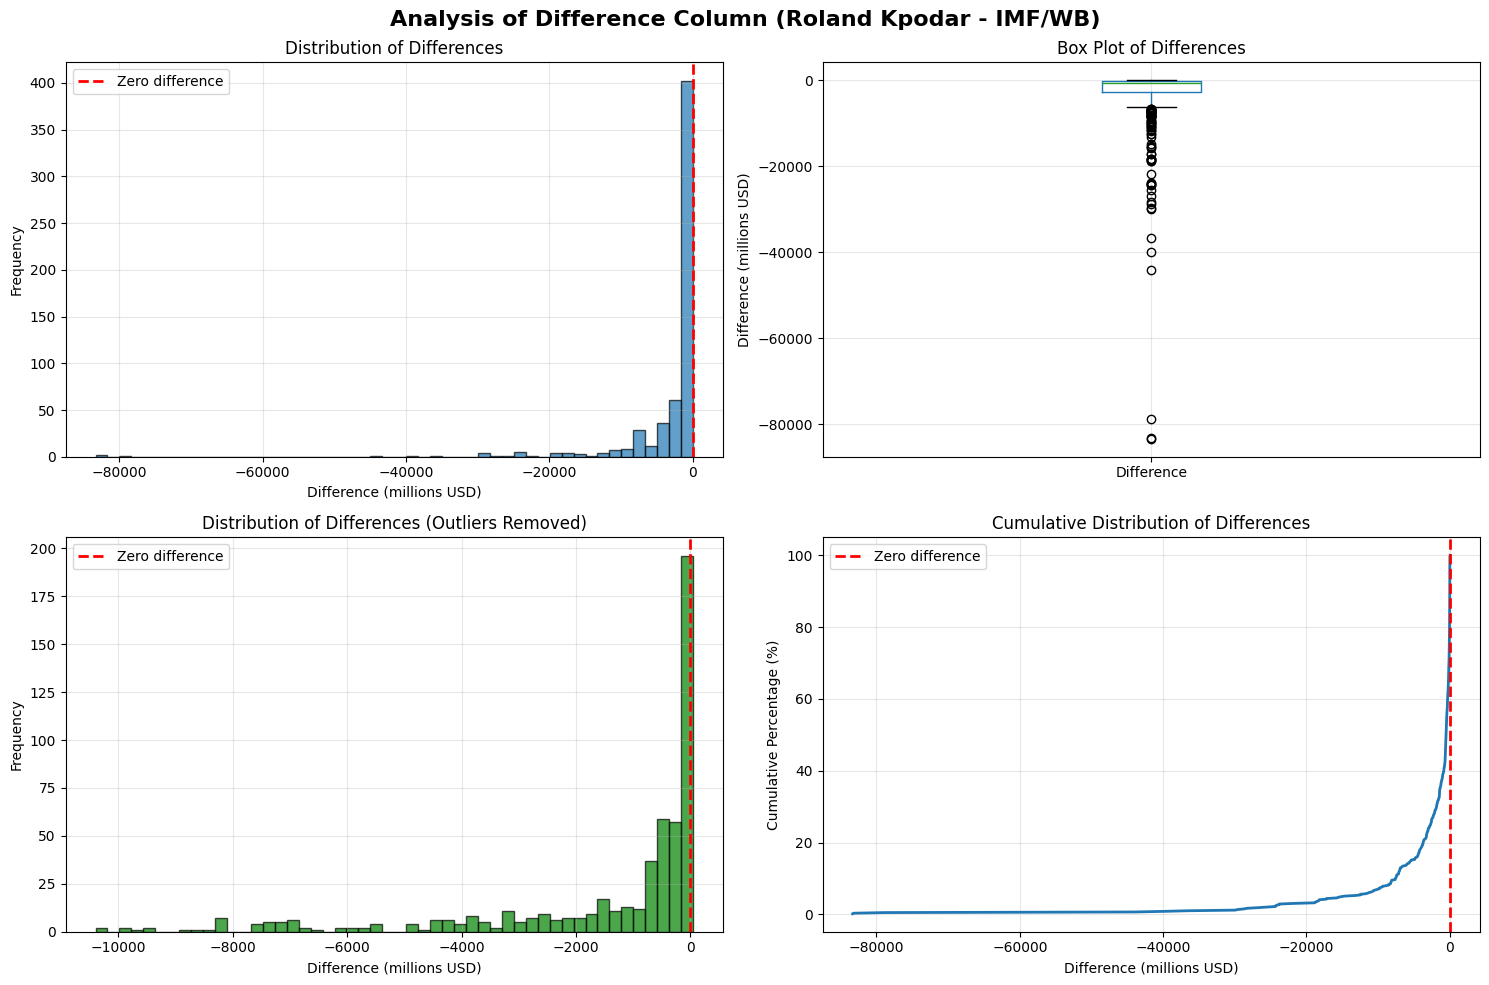


Note: The zoomed histogram excludes 93 extreme outliers for better visualization.


In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Analysis of Difference Column (Roland Kpodar - IMF/WB)', fontsize=16, fontweight='bold')

# 1. Histogram of all differences
ax1 = axes[0, 0]
df_comparison['Difference'].dropna().hist(bins=50, ax=ax1, edgecolor='black', alpha=0.7)
ax1.set_xlabel('Difference (millions USD)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Differences')
ax1.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero difference')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Box plot
ax2 = axes[0, 1]
df_comparison.boxplot(column='Difference', ax=ax2)
ax2.set_ylabel('Difference (millions USD)')
ax2.set_title('Box Plot of Differences')
ax2.grid(True, alpha=0.3)

# 3. Histogram zoomed in (removing extreme outliers for better view)
ax3 = axes[1, 0]
Q1 = df_comparison['Difference'].quantile(0.25)
Q3 = df_comparison['Difference'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR
filtered_diff = df_comparison['Difference'][(df_comparison['Difference'] >= lower_bound) & 
                                             (df_comparison['Difference'] <= upper_bound)]
filtered_diff.hist(bins=50, ax=ax3, edgecolor='black', alpha=0.7, color='green')
ax3.set_xlabel('Difference (millions USD)')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of Differences (Outliers Removed)')
ax3.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero difference')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Cumulative distribution
ax4 = axes[1, 1]
sorted_diff = np.sort(df_comparison['Difference'].dropna())
cumulative = np.arange(1, len(sorted_diff) + 1) / len(sorted_diff) * 100
ax4.plot(sorted_diff, cumulative, linewidth=2)
ax4.set_xlabel('Difference (millions USD)')
ax4.set_ylabel('Cumulative Percentage (%)')
ax4.set_title('Cumulative Distribution of Differences')
ax4.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero difference')
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.tight_layout()
plt.show()

print(f"\nNote: The zoomed histogram excludes {len(df_comparison) - len(filtered_diff)} extreme outliers for better visualization.")

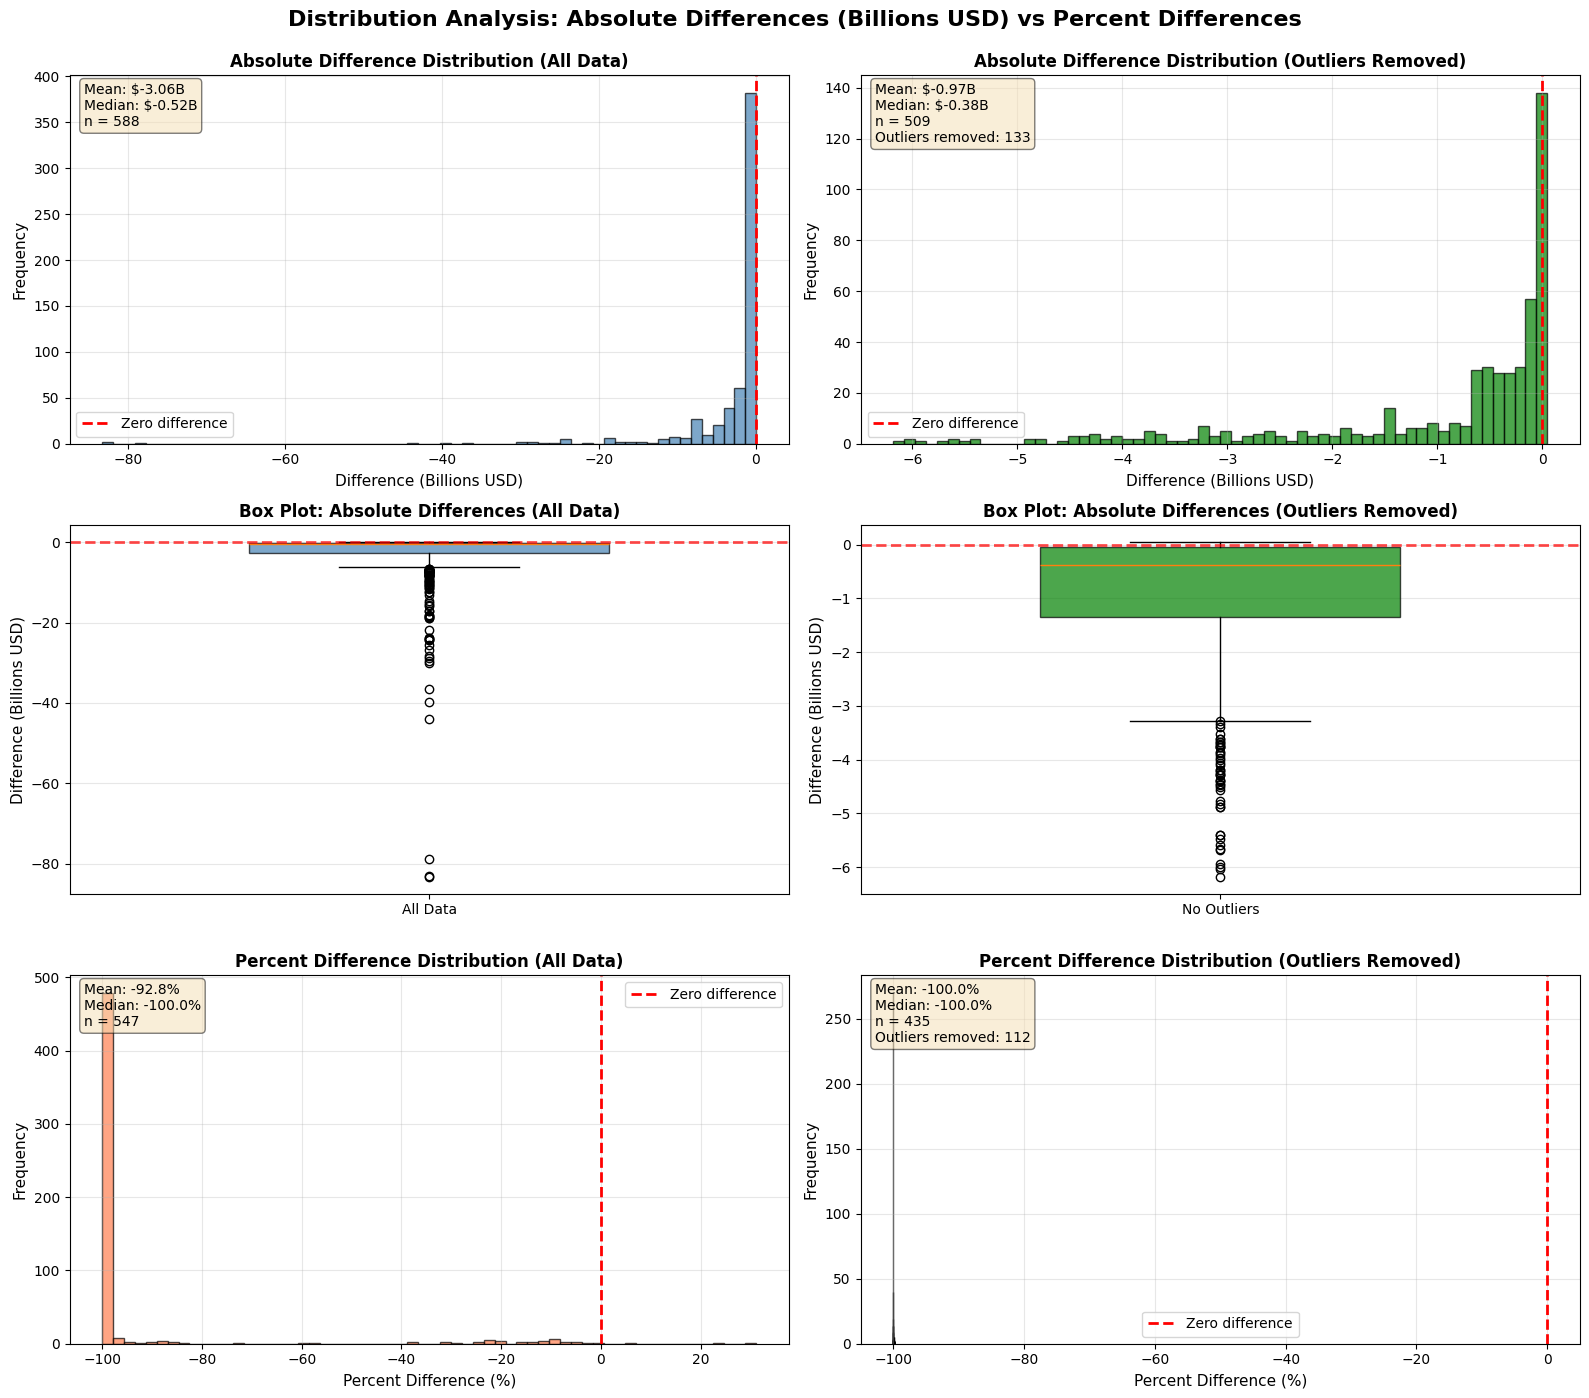

DISTRIBUTION COMPARISON SUMMARY

📊 ABSOLUTE DIFFERENCES (Billions USD):

  WITH OUTLIERS:
    • Count: 588
    • Mean: $-3.061B
    • Median: $-0.524B
    • Std Dev: $7.870B
    • Min: $-83.331B
    • Max: $0.046B

  WITHOUT OUTLIERS:
    • Count: 509
    • Outliers removed: 133 (20.7%)
    • Mean: $-0.973B
    • Median: $-0.379B
    • Std Dev: $1.376B
    • Min: $-6.181B
    • Max: $0.046B
    • Outlier bounds: [$-6.584B, $3.848B]

📊 PERCENT DIFFERENCES (%):

  WITH OUTLIERS:
    • Count: 547
    • Mean: -92.80%
    • Median: -100.00%
    • Std Dev: 23.23%
    • Min: -100.00%
    • Max: 31.15%

  WITHOUT OUTLIERS:
    • Count: 435
    • Outliers removed: 112 (20.5%)
    • Mean: -99.99%
    • Median: -100.00%
    • Std Dev: 0.03%
    • Min: -100.00%
    • Max: -99.82%
    • Outlier bounds: [-100.11%, -99.82%]



In [35]:
# Comprehensive Distribution Analysis - Differences and Percent Differences
import matplotlib.pyplot as plt
import numpy as np

# Convert differences to billions for better readability
df_comparison['Difference_Billions'] = df_comparison['Difference'] / 1000

# Calculate outlier bounds for Difference
Q1_diff = df_comparison['Difference'].quantile(0.25)
Q3_diff = df_comparison['Difference'].quantile(0.75)
IQR_diff = Q3_diff - Q1_diff
lower_bound_diff = Q1_diff - 1.5 * IQR_diff
upper_bound_diff = Q3_diff + 1.5 * IQR_diff

# Filter for non-outliers
df_no_outliers = df_comparison[
    (df_comparison['Difference'] >= lower_bound_diff) & 
    (df_comparison['Difference'] <= upper_bound_diff)
].copy()
df_no_outliers['Difference_Billions'] = df_no_outliers['Difference'] / 1000

# Calculate outlier bounds for Percent_Difference
df_pct_valid = df_comparison[
    df_comparison['Percent_Difference'].notna() & 
    np.isfinite(df_comparison['Percent_Difference'])
].copy()

Q1_pct = df_pct_valid['Percent_Difference'].quantile(0.25)
Q3_pct = df_pct_valid['Percent_Difference'].quantile(0.75)
IQR_pct = Q3_pct - Q1_pct
lower_bound_pct = Q1_pct - 1.5 * IQR_pct
upper_bound_pct = Q3_pct + 1.5 * IQR_pct

df_pct_no_outliers = df_pct_valid[
    (df_pct_valid['Percent_Difference'] >= lower_bound_pct) & 
    (df_pct_valid['Percent_Difference'] <= upper_bound_pct)
].copy()

# Create figure with 3 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
fig.suptitle('Distribution Analysis: Absolute Differences (Billions USD) vs Percent Differences', 
             fontsize=16, fontweight='bold', y=0.995)

# ===== ROW 1: ABSOLUTE DIFFERENCES (BILLIONS) =====

# 1.1 All differences (with outliers)
ax1 = axes[0, 0]
df_comparison['Difference_Billions'].dropna().hist(bins=60, ax=ax1, edgecolor='black', alpha=0.7, color='steelblue')
ax1.set_xlabel('Difference (Billions USD)', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Absolute Difference Distribution (All Data)', fontsize=12, fontweight='bold')
ax1.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero difference')
ax1.legend()
ax1.grid(True, alpha=0.3)
mean_val = df_comparison['Difference_Billions'].mean()
median_val = df_comparison['Difference_Billions'].median()
ax1.text(0.02, 0.98, f'Mean: ${mean_val:.2f}B\nMedian: ${median_val:.2f}B\nn = {df_comparison["Difference_Billions"].notna().sum():,}',
         transform=ax1.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 1.2 Differences without outliers
ax2 = axes[0, 1]
df_no_outliers['Difference_Billions'].hist(bins=60, ax=ax2, edgecolor='black', alpha=0.7, color='green')
ax2.set_xlabel('Difference (Billions USD)', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Absolute Difference Distribution (Outliers Removed)', fontsize=12, fontweight='bold')
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero difference')
ax2.legend()
ax2.grid(True, alpha=0.3)
mean_val_no = df_no_outliers['Difference_Billions'].mean()
median_val_no = df_no_outliers['Difference_Billions'].median()
outliers_removed = len(df_comparison) - len(df_no_outliers)
ax2.text(0.02, 0.98, f'Mean: ${mean_val_no:.2f}B\nMedian: ${median_val_no:.2f}B\nn = {len(df_no_outliers):,}\nOutliers removed: {outliers_removed}',
         transform=ax2.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# ===== ROW 2: BOX PLOTS =====

# 2.1 Box plot - All differences
ax3 = axes[1, 0]
bp1 = ax3.boxplot([df_comparison['Difference_Billions'].dropna()], vert=True, patch_artist=True, widths=0.5)
bp1['boxes'][0].set_facecolor('steelblue')
bp1['boxes'][0].set_alpha(0.7)
ax3.set_ylabel('Difference (Billions USD)', fontsize=11)
ax3.set_title('Box Plot: Absolute Differences (All Data)', fontsize=12, fontweight='bold')
ax3.set_xticklabels(['All Data'])
ax3.grid(True, alpha=0.3, axis='y')
ax3.axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.7)

# 2.2 Box plot - No outliers
ax4 = axes[1, 1]
bp2 = ax4.boxplot([df_no_outliers['Difference_Billions']], vert=True, patch_artist=True, widths=0.5)
bp2['boxes'][0].set_facecolor('green')
bp2['boxes'][0].set_alpha(0.7)
ax4.set_ylabel('Difference (Billions USD)', fontsize=11)
ax4.set_title('Box Plot: Absolute Differences (Outliers Removed)', fontsize=12, fontweight='bold')
ax4.set_xticklabels(['No Outliers'])
ax4.grid(True, alpha=0.3, axis='y')
ax4.axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.7)

# ===== ROW 3: PERCENT DIFFERENCES =====

# 3.1 All percent differences (with outliers)
ax5 = axes[2, 0]
df_pct_valid['Percent_Difference'].hist(bins=60, ax=ax5, edgecolor='black', alpha=0.7, color='coral')
ax5.set_xlabel('Percent Difference (%)', fontsize=11)
ax5.set_ylabel('Frequency', fontsize=11)
ax5.set_title('Percent Difference Distribution (All Data)', fontsize=12, fontweight='bold')
ax5.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero difference')
ax5.legend()
ax5.grid(True, alpha=0.3)
mean_pct = df_pct_valid['Percent_Difference'].mean()
median_pct = df_pct_valid['Percent_Difference'].median()
ax5.text(0.02, 0.98, f'Mean: {mean_pct:.1f}%\nMedian: {median_pct:.1f}%\nn = {len(df_pct_valid):,}',
         transform=ax5.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 3.2 Percent differences without outliers
ax6 = axes[2, 1]
df_pct_no_outliers['Percent_Difference'].hist(bins=60, ax=ax6, edgecolor='black', alpha=0.7, color='purple')
ax6.set_xlabel('Percent Difference (%)', fontsize=11)
ax6.set_ylabel('Frequency', fontsize=11)
ax6.set_title('Percent Difference Distribution (Outliers Removed)', fontsize=12, fontweight='bold')
ax6.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero difference')
ax6.legend()
ax6.grid(True, alpha=0.3)
mean_pct_no = df_pct_no_outliers['Percent_Difference'].mean()
median_pct_no = df_pct_no_outliers['Percent_Difference'].median()
pct_outliers_removed = len(df_pct_valid) - len(df_pct_no_outliers)
ax6.text(0.02, 0.98, f'Mean: {mean_pct_no:.1f}%\nMedian: {median_pct_no:.1f}%\nn = {len(df_pct_no_outliers):,}\nOutliers removed: {pct_outliers_removed}',
         transform=ax6.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Print summary statistics
print("=" * 90)
print("DISTRIBUTION COMPARISON SUMMARY")
print("=" * 90)

print("\n📊 ABSOLUTE DIFFERENCES (Billions USD):")
print(f"\n  WITH OUTLIERS:")
print(f"    • Count: {df_comparison['Difference_Billions'].notna().sum():,}")
print(f"    • Mean: ${df_comparison['Difference_Billions'].mean():.3f}B")
print(f"    • Median: ${df_comparison['Difference_Billions'].median():.3f}B")
print(f"    • Std Dev: ${df_comparison['Difference_Billions'].std():.3f}B")
print(f"    • Min: ${df_comparison['Difference_Billions'].min():.3f}B")
print(f"    • Max: ${df_comparison['Difference_Billions'].max():.3f}B")

print(f"\n  WITHOUT OUTLIERS:")
print(f"    • Count: {len(df_no_outliers):,}")
print(f"    • Outliers removed: {len(df_comparison) - len(df_no_outliers):,} ({(len(df_comparison) - len(df_no_outliers))/len(df_comparison)*100:.1f}%)")
print(f"    • Mean: ${df_no_outliers['Difference_Billions'].mean():.3f}B")
print(f"    • Median: ${df_no_outliers['Difference_Billions'].median():.3f}B")
print(f"    • Std Dev: ${df_no_outliers['Difference_Billions'].std():.3f}B")
print(f"    • Min: ${df_no_outliers['Difference_Billions'].min():.3f}B")
print(f"    • Max: ${df_no_outliers['Difference_Billions'].max():.3f}B")
print(f"    • Outlier bounds: [${lower_bound_diff/1000:.3f}B, ${upper_bound_diff/1000:.3f}B]")

print("\n📊 PERCENT DIFFERENCES (%):")
print(f"\n  WITH OUTLIERS:")
print(f"    • Count: {len(df_pct_valid):,}")
print(f"    • Mean: {df_pct_valid['Percent_Difference'].mean():.2f}%")
print(f"    • Median: {df_pct_valid['Percent_Difference'].median():.2f}%")
print(f"    • Std Dev: {df_pct_valid['Percent_Difference'].std():.2f}%")
print(f"    • Min: {df_pct_valid['Percent_Difference'].min():.2f}%")
print(f"    • Max: {df_pct_valid['Percent_Difference'].max():.2f}%")

print(f"\n  WITHOUT OUTLIERS:")
print(f"    • Count: {len(df_pct_no_outliers):,}")
print(f"    • Outliers removed: {pct_outliers_removed:,} ({pct_outliers_removed/len(df_pct_valid)*100:.1f}%)")
print(f"    • Mean: {df_pct_no_outliers['Percent_Difference'].mean():.2f}%")
print(f"    • Median: {df_pct_no_outliers['Percent_Difference'].median():.2f}%")
print(f"    • Std Dev: {df_pct_no_outliers['Percent_Difference'].std():.2f}%")
print(f"    • Min: {df_pct_no_outliers['Percent_Difference'].min():.2f}%")
print(f"    • Max: {df_pct_no_outliers['Percent_Difference'].max():.2f}%")
print(f"    • Outlier bounds: [{lower_bound_pct:.2f}%, {upper_bound_pct:.2f}%]")

print("\n" + "=" * 90)

In [36]:
# Compare Philippine remittance numbers
# Given numbers (assuming these are in thousands USD based on the magnitude)
philippine_reference = {
    2022: 32_539_430,  # Will determine the unit
    2023: 33_490_930,
    2024: 34_492_616
}

print("=" * 90)
print("PHILIPPINE REMITTANCE COMPARISON")
print("=" * 90)

# Filter df_comparison for Philippines
df_philippines = df_comparison[
    df_comparison['Receiving_Country'].str.contains('Philippines', case=False, na=False)
].copy()

print(f"\n📍 Philippines data found in df_comparison:")
print(f"   Unique country names: {df_philippines['Receiving_Country'].unique()}")
print(f"   Years available: {sorted(df_philippines['Year'].unique())}")
print(f"   Total rows: {len(df_philippines)}")

if len(df_philippines) > 0:
    print("\n" + "=" * 90)
    print("DETAILED COMPARISON")
    print("=" * 90)
    
    for year, ref_value in philippine_reference.items():
        print(f"\n📅 YEAR {year}:")
        
        # Get data for this year
        ph_year = df_philippines[df_philippines['Year'] == year]
        
        if len(ph_year) > 0:
            # Roland Kpodar value (in millions)
            roland_value_millions = ph_year['Value'].iloc[0]
            roland_value_thousands = roland_value_millions * 1000  # Convert to thousands
            
            # IMF/WB value (in millions)
            imf_wb_value_millions = ph_year['IMF_WB_Value'].iloc[0] if pd.notna(ph_year['IMF_WB_Value'].iloc[0]) else None
            imf_wb_value_thousands = imf_wb_value_millions * 1000 if imf_wb_value_millions else None
            
            print(f"   Reference value: {ref_value:>15,.0f} (thousands USD = ${ref_value/1000:,.2f}M)")
            print(f"   Roland Kpodar:   {roland_value_thousands:>15,.0f} (thousands USD = ${roland_value_millions:,.2f}M)")
            
            if imf_wb_value_thousands:
                print(f"   IMF/WB:          {imf_wb_value_thousands:>15,.0f} (thousands USD = ${imf_wb_value_millions:,.2f}M)")
            else:
                print(f"   IMF/WB:          {'N/A':>15}")
            
            # Calculate differences from reference
            diff_roland = roland_value_thousands - ref_value
            pct_diff_roland = (diff_roland / ref_value) * 100
            
            print(f"\n   📊 Roland Kpodar vs Reference:")
            print(f"      Difference: {diff_roland:>15,.0f} thousands USD (${diff_roland/1000:,.2f}M)")
            print(f"      Percent:    {pct_diff_roland:>15.2f}%")
            
            if imf_wb_value_thousands:
                diff_imf = imf_wb_value_thousands - ref_value
                pct_diff_imf = (diff_imf / ref_value) * 100
                
                print(f"\n   📊 IMF/WB vs Reference:")
                print(f"      Difference: {diff_imf:>15,.0f} thousands USD (${diff_imf/1000:,.2f}M)")
                print(f"      Percent:    {pct_diff_imf:>15.2f}%")
                
                # Comparison between the two datasets
                print(f"\n   📊 Roland Kpodar vs IMF/WB:")
                print(f"      Difference: {(roland_value_thousands - imf_wb_value_thousands):>15,.0f} thousands USD")
                print(f"      Percent:    {((roland_value_thousands - imf_wb_value_thousands)/imf_wb_value_thousands)*100:>15.2f}%")
        else:
            print(f"   ⚠️ No data available for {year}")
            print(f"   Reference value: {ref_value:,.0f} (thousands USD = ${ref_value/1000:,.2f}M)")

    # Show all Philippines data
    print("\n" + "=" * 90)
    print("FULL PHILIPPINES DATA FROM df_comparison")
    print("=" * 90)
    
    display_cols = ['Receiving_Country', 'Year', 'Value', 'IMF_WB_Value', 'Difference', 'Percent_Difference', '_merge']
    ph_display = df_philippines[display_cols].copy()
    ph_display['Value_Thousands'] = ph_display['Value'] * 1000
    ph_display['IMF_WB_Thousands'] = ph_display['IMF_WB_Value'] * 1000
    
    print("\nAll available years:")
    print(ph_display[['Year', 'Value', 'Value_Thousands', 'IMF_WB_Value', 'IMF_WB_Thousands', 'Difference', 'Percent_Difference']].to_string(index=False))
    
else:
    print("\n⚠️ No Philippines data found in df_comparison!")
    print("\nLet's check what countries we have:")
    print(df_comparison['Receiving_Country'].unique()[:20])

print("\n" + "=" * 90)
print("\n💡 NOTE: Reference values appear to be in THOUSANDS USD")
print("   - 32,539,430 thousands = $32.54 billion")
print("   - 33,490,930 thousands = $33.49 billion")
print("   - 34,492,616 thousands = $34.49 billion")

PHILIPPINE REMITTANCE COMPARISON

📍 Philippines data found in df_comparison:
   Unique country names: ['Philippines']
   Years available: [np.int64(2018), np.int64(2019), np.int64(2020)]
   Total rows: 3

DETAILED COMPARISON

📅 YEAR 2022:
   ⚠️ No data available for 2022
   Reference value: 32,539,430 (thousands USD = $32,539.43M)

📅 YEAR 2023:
   ⚠️ No data available for 2023
   Reference value: 33,490,930 (thousands USD = $33,490.93M)

📅 YEAR 2024:
   ⚠️ No data available for 2024
   Reference value: 34,492,616 (thousands USD = $34,492.62M)

FULL PHILIPPINES DATA FROM df_comparison

All available years:
 Year        Value  Value_Thousands  IMF_WB_Value  IMF_WB_Thousands   Difference  Percent_Difference
 2018 28325.506109     2.832551e+07  33808.967986      33808967.986 -5483.461877          -16.218957
 2019 29485.850070     2.948585e+07  35167.471832      35167471.832 -5681.621762          -16.155901
 2020 26364.993284     2.636499e+07  34882.844550      34882844.550 -8517.851266    

PHILIPPINE REMITTANCE COMPARISON - UPDATED (2018-2020)

📍 Philippines data found in df_comparison:
   Unique country names: ['Philippines']
   Years available: [np.int64(2018), np.int64(2019), np.int64(2020)]
   Total rows: 3

DETAILED YEAR-BY-YEAR COMPARISON

📅 YEAR 2018:
   📊 PHILIPPINE CENTRAL BANK (Official Data):
           28,943,112 thousands USD = $ 28,943.11 M = $  28.94 B

   📊 ROLAND KPODAR:
           28,325,506 thousands USD = $ 28,325.51 M = $  28.33 B

   📊 IMF/WB:
           33,808,968 thousands USD = $ 33,808.97 M = $  33.81 B

   🔍 ROLAND KPODAR vs CENTRAL BANK:
      Absolute Diff:         -617,606 thousands ($   -617.61 M)
      Percent Diff:             -2.13%
      ✗ LOWER than Central Bank

   🔍 IMF/WB vs CENTRAL BANK:
      Absolute Diff:        4,865,856 thousands ($  4,865.86 M)
      Percent Diff:             16.81%
      ✓ HIGHER than Central Bank

   🔍 ROLAND KPODAR vs IMF/WB:
      Absolute Diff:       -5,483,462 thousands ($ -5,483.46 M)
      Percent Dif

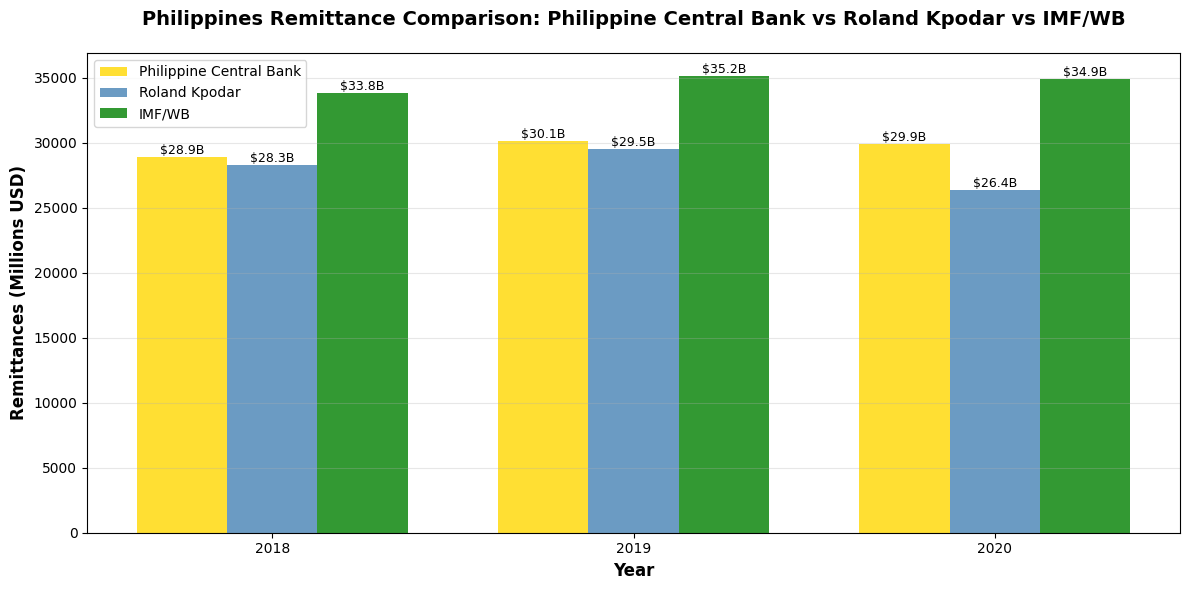


PERCENT DIFFERENCE VISUALIZATION


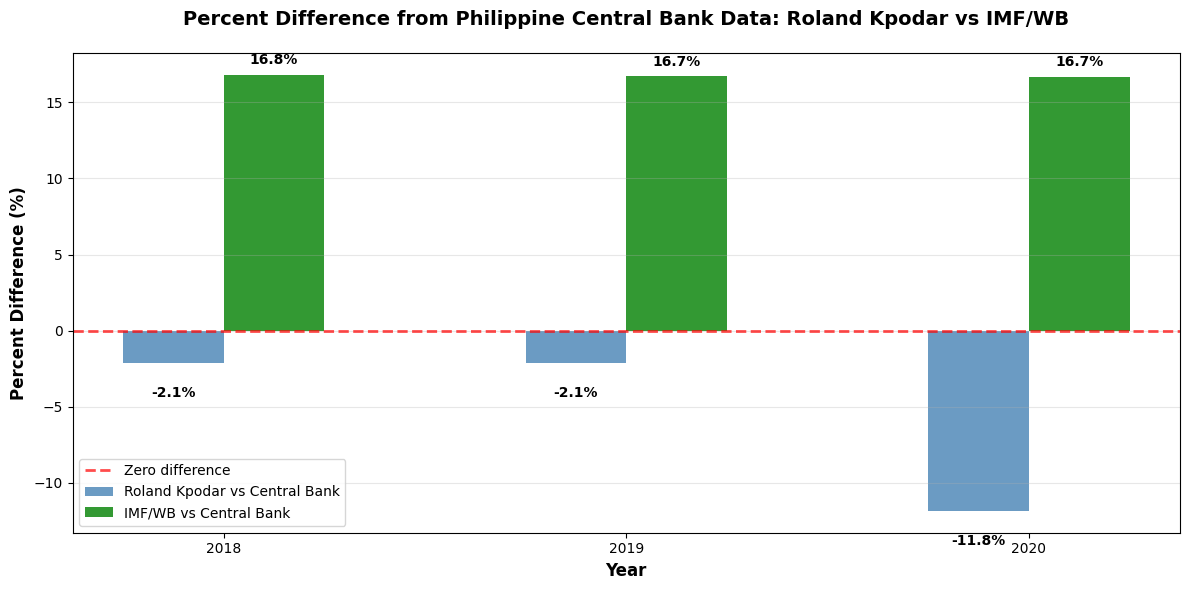


KEY FINDINGS

1. ROLAND KPODAR vs PHILIPPINE CENTRAL BANK:
   Average difference: -5.37%
   Roland Kpodar consistently UNDERESTIMATES by ~5.4%

2. IMF/WB vs PHILIPPINE CENTRAL BANK:
   Average difference: 16.72%
   IMF/WB consistently OVERESTIMATES by ~16.7%

3. CLOSEST MATCH:
   Roland Kpodar is CLOSER to Philippine Central Bank data



In [39]:
# Updated Philippine remittance comparison with 2018-2020 data
# Reference numbers (in thousands USD)
philippine_reference_updated = {
    2018: 28_943_112,
    2019: 30_133_300,
    2020: 29_903_256
}

print("=" * 90)
print("PHILIPPINE REMITTANCE COMPARISON - UPDATED (2018-2020)")
print("=" * 90)

# Filter df_comparison for Philippines
df_philippines = df_comparison[
    df_comparison['Receiving_Country'].str.contains('Philippines', case=False, na=False)
].copy()

print(f"\n📍 Philippines data found in df_comparison:")
print(f"   Unique country names: {df_philippines['Receiving_Country'].unique()}")
print(f"   Years available: {sorted(df_philippines['Year'].unique())}")
print(f"   Total rows: {len(df_philippines)}")

if len(df_philippines) > 0:
    print("\n" + "=" * 90)
    print("DETAILED YEAR-BY-YEAR COMPARISON")
    print("=" * 90)
    
    comparison_data = []
    
    for year, ref_value in philippine_reference_updated.items():
        print(f"\n📅 YEAR {year}:")
        print("=" * 90)
        
        # Get data for this year
        ph_year = df_philippines[df_philippines['Year'] == year]
        
        if len(ph_year) > 0:
            # Roland Kpodar value (in millions)
            roland_value_millions = ph_year['Value'].iloc[0]
            roland_value_thousands = roland_value_millions * 1000  # Convert to thousands
            
            # IMF/WB value (in millions)
            imf_wb_value_millions = ph_year['IMF_WB_Value'].iloc[0] if pd.notna(ph_year['IMF_WB_Value'].iloc[0]) else None
            imf_wb_value_thousands = imf_wb_value_millions * 1000 if imf_wb_value_millions else None
            
            print(f"   📊 PHILIPPINE CENTRAL BANK (Official Data):")
            print(f"      {ref_value:>15,.0f} thousands USD = ${ref_value/1000:>10,.2f} M = ${ref_value/1_000_000:>7,.2f} B")
            
            print(f"\n   📊 ROLAND KPODAR:")
            print(f"      {roland_value_thousands:>15,.0f} thousands USD = ${roland_value_millions:>10,.2f} M = ${roland_value_millions/1000:>7,.2f} B")
            
            if imf_wb_value_thousands:
                print(f"\n   📊 IMF/WB:")
                print(f"      {imf_wb_value_thousands:>15,.0f} thousands USD = ${imf_wb_value_millions:>10,.2f} M = ${imf_wb_value_millions/1000:>7,.2f} B")
            else:
                print(f"\n   📊 IMF/WB: N/A")
            
            # Calculate differences from reference
            diff_roland = roland_value_thousands - ref_value
            pct_diff_roland = (diff_roland / ref_value) * 100
            
            print(f"\n   🔍 ROLAND KPODAR vs CENTRAL BANK:")
            print(f"      Absolute Diff:  {diff_roland:>15,.0f} thousands (${diff_roland/1000:>10,.2f} M)")
            print(f"      Percent Diff:   {pct_diff_roland:>15.2f}%")
            print(f"      {'✓ HIGHER' if diff_roland > 0 else '✗ LOWER'} than Central Bank")
            
            comparison_row = {
                'Year': year,
                'Reference': ref_value / 1000,
                'Roland_Kpodar': roland_value_millions,
                'IMF_WB': imf_wb_value_millions if imf_wb_value_millions else None,
                'RK_vs_Ref_Diff': diff_roland / 1000,
                'RK_vs_Ref_Pct': pct_diff_roland
            }
            
            if imf_wb_value_thousands:
                diff_imf = imf_wb_value_thousands - ref_value
                pct_diff_imf = (diff_imf / ref_value) * 100
                
                print(f"\n   🔍 IMF/WB vs CENTRAL BANK:")
                print(f"      Absolute Diff:  {diff_imf:>15,.0f} thousands (${diff_imf/1000:>10,.2f} M)")
                print(f"      Percent Diff:   {pct_diff_imf:>15.2f}%")
                print(f"      {'✓ HIGHER' if diff_imf > 0 else '✗ LOWER'} than Central Bank")
                
                comparison_row['IMF_vs_Ref_Diff'] = diff_imf / 1000
                comparison_row['IMF_vs_Ref_Pct'] = pct_diff_imf
                
                # Comparison between the two datasets
                diff_datasets = roland_value_thousands - imf_wb_value_thousands
                pct_diff_datasets = (diff_datasets / imf_wb_value_thousands) * 100
                
                print(f"\n   🔍 ROLAND KPODAR vs IMF/WB:")
                print(f"      Absolute Diff:  {diff_datasets:>15,.0f} thousands (${diff_datasets/1000:>10,.2f} M)")
                print(f"      Percent Diff:   {pct_diff_datasets:>15.2f}%")
            
            comparison_data.append(comparison_row)
        else:
            print(f"   ⚠️ No data available for {year}")
            print(f"   Reference value: {ref_value:,.0f} (thousands USD = ${ref_value/1000:,.2f}M)")

    # Create summary table
    print("\n" + "=" * 90)
    print("SUMMARY TABLE (All values in MILLIONS USD)")
    print("=" * 90)
    
    df_summary = pd.DataFrame(comparison_data)
    print("\n" + df_summary.to_string(index=False, float_format=lambda x: f'{x:,.2f}'))
    
    # Visual comparison
    print("\n" + "=" * 90)
    print("VISUAL COMPARISON")
    print("=" * 90)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    years = df_summary['Year'].values
    x = np.arange(len(years))
    width = 0.25
    
    bars1 = ax.bar(x - width, df_summary['Reference'].values, width, label='Philippine Central Bank', color='gold', alpha=0.8)
    bars2 = ax.bar(x, df_summary['Roland_Kpodar'].values, width, label='Roland Kpodar', color='steelblue', alpha=0.8)
    
    if df_summary['IMF_WB'].notna().any():
        bars3 = ax.bar(x + width, df_summary['IMF_WB'].values, width, label='IMF/WB', color='green', alpha=0.8)
    
    ax.set_xlabel('Year', fontsize=12, fontweight='bold')
    ax.set_ylabel('Remittances (Millions USD)', fontsize=12, fontweight='bold')
    ax.set_title('Philippines Remittance Comparison: Philippine Central Bank vs Roland Kpodar vs IMF/WB', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(years)
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            if not np.isnan(height):
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'${height/1000:.1f}B',
                       ha='center', va='bottom', fontsize=9)
    
    add_labels(bars1)
    add_labels(bars2)
    if df_summary['IMF_WB'].notna().any():
        add_labels(bars3)
    
    plt.tight_layout()
    plt.show()
    
    # Percent Difference Visualization
    print("\n" + "=" * 90)
    print("PERCENT DIFFERENCE VISUALIZATION")
    print("=" * 90)
    
    fig2, ax2 = plt.subplots(figsize=(12, 6))
    
    # Create bars for percent differences
    bars_pct1 = ax2.bar(x - width/2, df_summary['RK_vs_Ref_Pct'].values, width, 
                        label='Roland Kpodar vs Central Bank', color='steelblue', alpha=0.8)
    
    if 'IMF_vs_Ref_Pct' in df_summary.columns and df_summary['IMF_vs_Ref_Pct'].notna().any():
        bars_pct2 = ax2.bar(x + width/2, df_summary['IMF_vs_Ref_Pct'].values, width, 
                           label='IMF/WB vs Central Bank', color='green', alpha=0.8)
    
    # Add a zero reference line
    ax2.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Zero difference')
    
    ax2.set_xlabel('Year', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Percent Difference (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Percent Difference from Philippine Central Bank Data: Roland Kpodar vs IMF/WB', 
                 fontsize=14, fontweight='bold', pad=20)
    ax2.set_xticks(x)
    ax2.set_xticklabels(years)
    ax2.legend(loc='best', fontsize=10)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    def add_pct_labels(bars):
        for bar in bars:
            height = bar.get_height()
            if not np.isnan(height):
                label_y = height + (0.5 if height >= 0 else -1.5)
                ax2.text(bar.get_x() + bar.get_width()/2., label_y,
                       f'{height:.1f}%',
                       ha='center', va='bottom' if height >= 0 else 'top', fontsize=10, fontweight='bold')
    
    add_pct_labels(bars_pct1)
    if 'IMF_vs_Ref_Pct' in df_summary.columns and df_summary['IMF_vs_Ref_Pct'].notna().any():
        add_pct_labels(bars_pct2)
    
    plt.tight_layout()
    plt.show()
    
    # Key findings
    print("\n" + "=" * 90)
    print("KEY FINDINGS")
    print("=" * 90)
    
    avg_rk_vs_ref = df_summary['RK_vs_Ref_Pct'].mean()
    if 'IMF_vs_Ref_Pct' in df_summary.columns:
        avg_imf_vs_ref = df_summary['IMF_vs_Ref_Pct'].mean()
    
    print(f"\n1. ROLAND KPODAR vs PHILIPPINE CENTRAL BANK:")
    print(f"   Average difference: {avg_rk_vs_ref:.2f}%")
    if avg_rk_vs_ref < 0:
        print(f"   Roland Kpodar consistently UNDERESTIMATES by ~{abs(avg_rk_vs_ref):.1f}%")
    else:
        print(f"   Roland Kpodar consistently OVERESTIMATES by ~{avg_rk_vs_ref:.1f}%")
    
    if 'IMF_vs_Ref_Pct' in df_summary.columns:
        print(f"\n2. IMF/WB vs PHILIPPINE CENTRAL BANK:")
        print(f"   Average difference: {avg_imf_vs_ref:.2f}%")
        if avg_imf_vs_ref < 0:
            print(f"   IMF/WB consistently UNDERESTIMATES by ~{abs(avg_imf_vs_ref):.1f}%")
        else:
            print(f"   IMF/WB consistently OVERESTIMATES by ~{avg_imf_vs_ref:.1f}%")
    
    print(f"\n3. CLOSEST MATCH:")
    if 'IMF_vs_Ref_Pct' in df_summary.columns:
        if abs(avg_rk_vs_ref) < abs(avg_imf_vs_ref):
            print(f"   Roland Kpodar is CLOSER to Philippine Central Bank data")
        else:
            print(f"   IMF/WB is CLOSER to Philippine Central Bank data")
    
else:
    print("\n⚠️ No Philippines data found in df_comparison!")

print("\n" + "=" * 90)

In [30]:
import plotly.express as px

# For the map, we need to aggregate by country (average difference across all years)
# This gives us one value per country to display
df_map = df_comparison.groupby(['Country_Code', 'Receiving_Country']).agg({
    'Difference': 'mean',
    'Value': 'mean',
    'IMF_WB_Value': 'mean'
}).reset_index()

# Create the choropleth map
fig = px.choropleth(
    df_map,
    locations='Country_Code',
    color='Difference',
    hover_name='Receiving_Country',
    hover_data={
        'Country_Code': True,
        'Difference': ':.2f',
        'Value': ':.2f',
        'IMF_WB_Value': ':.2f'
    },
    color_continuous_scale='RdBu_r',  # Red for negative, Blue for positive
    color_continuous_midpoint=0,
    title='Average Remittance Difference by Country (Roland Kpodar - IMF/WB)<br><sub>Values in millions USD, averaged across all years</sub>',
    labels={'Difference': 'Avg Difference (M USD)'}
)

fig.update_layout(
    height=600,
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='natural earth'
    )
)

fig.show()

print(f"\nMap showing {len(df_map)} countries")
print(f"Red countries: Roland Kpodar estimates are LOWER than IMF/WB")
print(f"Blue countries: Roland Kpodar estimates are HIGHER than IMF/WB")


Map showing 209 countries
Red countries: Roland Kpodar estimates are LOWER than IMF/WB
Blue countries: Roland Kpodar estimates are HIGHER than IMF/WB


In [31]:
# Average Remittance Difference Map - Without Outliers
# Remove outliers using IQR method
df_map_no_outliers = df_comparison.groupby(['Country_Code', 'Receiving_Country']).agg({
    'Difference': 'mean',
    'Value': 'mean',
    'IMF_WB_Value': 'mean'
}).reset_index()

# Calculate IQR and filter outliers
Q1 = df_map_no_outliers['Difference'].quantile(0.25)
Q3 = df_map_no_outliers['Difference'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df_map_filtered = df_map_no_outliers[
    (df_map_no_outliers['Difference'] >= lower_bound) & 
    (df_map_no_outliers['Difference'] <= upper_bound)
].copy()

print(f"Original countries: {len(df_map_no_outliers)}")
print(f"Countries after removing outliers: {len(df_map_filtered)}")
print(f"Outliers removed: {len(df_map_no_outliers) - len(df_map_filtered)}")
print(f"\nOutlier bounds:")
print(f"  Lower bound: {lower_bound:.2f} M USD")
print(f"  Upper bound: {upper_bound:.2f} M USD")
print(f"\nFiltered difference range:")
print(f"  Min: {df_map_filtered['Difference'].min():.2f} M USD")
print(f"  Max: {df_map_filtered['Difference'].max():.2f} M USD")

# Create the choropleth map without outliers
fig_no_outliers = px.choropleth(
    df_map_filtered,
    locations='Country_Code',
    color='Difference',
    hover_name='Receiving_Country',
    hover_data={
        'Country_Code': True,
        'Difference': ':.2f',
        'Value': ':.2f',
        'IMF_WB_Value': ':.2f'
    },
    color_continuous_scale='RdBu_r',
    color_continuous_midpoint=0,
    title='Average Remittance Difference by Country - Outliers Removed (Roland Kpodar - IMF/WB)<br><sub>Values in millions USD, averaged across all years (IQR method applied)</sub>',
    labels={'Difference': 'Avg Difference (M USD)'}
)

fig_no_outliers.update_layout(
    height=600,
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='natural earth'
    )
)

fig_no_outliers.show()

print(f"\nRed countries: Roland Kpodar estimates are LOWER than IMF/WB")
print(f"Blue countries: Roland Kpodar estimates are HIGHER than IMF/WB")
print(f"\nNote: Countries with extreme differences are excluded for better visualization")

Original countries: 209
Countries after removing outliers: 169
Outliers removed: 40

Outlier bounds:
  Lower bound: -6486.28 M USD
  Upper bound: 3783.99 M USD

Filtered difference range:
  Min: -6072.41 M USD
  Max: 32.04 M USD



Red countries: Roland Kpodar estimates are LOWER than IMF/WB
Blue countries: Roland Kpodar estimates are HIGHER than IMF/WB

Note: Countries with extreme differences are excluded for better visualization


In [32]:
# Create an animated choropleth map showing differences over time
# Filter to only rows where both datasets have data
df_map_time = df_comparison[df_comparison['_merge'] == 'both'].copy()

fig_time = px.choropleth(
    df_map_time,
    locations='Country_Code',
    color='Difference',
    hover_name='Receiving_Country',
    hover_data={
        'Country_Code': True,
        'Year': True,
        'Difference': ':.2f',
        'Value': ':.2f',
        'IMF_WB_Value': ':.2f',
        'Percent_Difference': ':.1f'
    },
    animation_frame='Year',
    color_continuous_scale='RdBu_r',
    color_continuous_midpoint=0,
    range_color=[-10000, 10000],  # Set a reasonable range for better visualization
    title='Remittance Difference by Country Over Time (Roland Kpodar - IMF/WB)<br><sub>Values in millions USD</sub>',
    labels={'Difference': 'Difference (M USD)'}
)

fig_time.update_layout(
    height=600,
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='natural earth'
    )
)

fig_time.show()

print(f"\nAnimated map showing {df_map_time['Country_Code'].nunique()} countries")
print(f"Time period: {df_map_time['Year'].min()} - {df_map_time['Year'].max()}")
print(f"Total data points: {len(df_map_time)}")
print(f"\nUse the play button or slider to see how differences change over time!")


Animated map showing 194 countries
Time period: 2018 - 2020
Total data points: 588

Use the play button or slider to see how differences change over time!


In [33]:
# Map 1: Average Percent Difference by Country
df_map_pct = df_comparison[df_comparison['_merge'] == 'both'].groupby(['Country_Code', 'Receiving_Country']).agg({
    'Percent_Difference': 'mean',
    'Difference': 'mean',
    'Value': 'mean',
    'IMF_WB_Value': 'mean'
}).reset_index()

fig_pct = px.choropleth(
    df_map_pct,
    locations='Country_Code',
    color='Percent_Difference',
    hover_name='Receiving_Country',
    hover_data={
        'Country_Code': True,
        'Percent_Difference': ':.1f',
        'Difference': ':.2f',
        'Value': ':.2f',
        'IMF_WB_Value': ':.2f'
    },
    color_continuous_scale='RdBu_r',
    color_continuous_midpoint=0,
    range_color=[-100, 100],  # Set range to ±100%
    title='Average Percent Difference in Remittances by Country (Roland Kpodar - IMF/WB)<br><sub>Percent difference averaged across all years</sub>',
    labels={'Percent_Difference': 'Avg % Difference'}
)

fig_pct.update_layout(
    height=600,
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='natural earth'
    )
)

fig_pct.show()

print(f"\nMap showing {len(df_map_pct)} countries")
print(f"Red countries: Roland Kpodar estimates are LOWER than IMF/WB (negative %)")
print(f"Blue countries: Roland Kpodar estimates are HIGHER than IMF/WB (positive %)")
print(f"\nPercent Difference Statistics:")
print(f"  Mean: {df_map_pct['Percent_Difference'].mean():.2f}%")
print(f"  Median: {df_map_pct['Percent_Difference'].median():.2f}%")
print(f"  Min: {df_map_pct['Percent_Difference'].min():.2f}%")
print(f"  Max: {df_map_pct['Percent_Difference'].max():.2f}%")


Map showing 196 countries
Red countries: Roland Kpodar estimates are LOWER than IMF/WB (negative %)
Blue countries: Roland Kpodar estimates are HIGHER than IMF/WB (positive %)

Percent Difference Statistics:
  Mean: inf%
  Median: -99.99%
  Min: -100.00%
  Max: inf%


In [34]:
# Map 2: Animated Percent Difference Over Time
# Filter to only rows where both datasets have data and finite percent differences
df_map_time_pct = df_comparison[
    (df_comparison['_merge'] == 'both') & 
    (df_comparison['Percent_Difference'].notna()) &
    (np.isfinite(df_comparison['Percent_Difference']))
].copy()

fig_time_pct = px.choropleth(
    df_map_time_pct,
    locations='Country_Code',
    color='Percent_Difference',
    hover_name='Receiving_Country',
    hover_data={
        'Country_Code': True,
        'Year': True,
        'Percent_Difference': ':.1f',
        'Difference': ':.2f',
        'Value': ':.2f',
        'IMF_WB_Value': ':.2f'
    },
    animation_frame='Year',
    color_continuous_scale='RdBu_r',
    color_continuous_midpoint=0,
    range_color=[-100, 100],  # Set range to ±100%
    title='Percent Difference in Remittances Over Time (Roland Kpodar - IMF/WB)<br><sub>Percentage difference by year</sub>',
    labels={'Percent_Difference': '% Difference'}
)

fig_time_pct.update_layout(
    height=600,
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='natural earth'
    )
)

fig_time_pct.show()

print(f"\nAnimated map showing {df_map_time_pct['Country_Code'].nunique()} countries")
print(f"Time period: {df_map_time_pct['Year'].min()} - {df_map_time_pct['Year'].max()}")
print(f"Total data points: {len(df_map_time_pct)}")
print(f"\nPercent Difference Statistics (all years):")
print(f"  Mean: {df_map_time_pct['Percent_Difference'].mean():.2f}%")
print(f"  Median: {df_map_time_pct['Percent_Difference'].median():.2f}%")
print(f"  25th percentile: {df_map_time_pct['Percent_Difference'].quantile(0.25):.2f}%")
print(f"  75th percentile: {df_map_time_pct['Percent_Difference'].quantile(0.75):.2f}%")
print(f"\nUse the play button or slider to see how percent differences change over time!")


Animated map showing 183 countries
Time period: 2018 - 2020
Total data points: 547

Percent Difference Statistics (all years):
  Mean: -92.80%
  Median: -100.00%
  25th percentile: -100.00%
  75th percentile: -99.93%

Use the play button or slider to see how percent differences change over time!
